# Import modules needed

In [1]:
import numpy as np
import random
from scipy.spatial import distance
from scipy.stats import mode, skew, kurtosis
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
from tqdm import tqdm

# Functions

These functions below deal with the Elmegreen fractal generating algorithm itself.

The funtion `coord_func` is equivalent to the equation:

$$
x_n = x_{n-1} + \frac{|2\mathcal{L} - 1 |}{\mathcal{S}^g}
$$

where $\mathcal L$ is a linear random deviate on the interval $[0,1]$, $\mathcal S$ is the scaling parameter as described by Elmegreen (1997), and $g$ is the generation. This function generates $\mathcal F$ values of $x_n$, described as the number of children.

The function `fractal_point_gen` defines the logic needed to generate the points which constitute the fractal field. The `integer` parameter let's the function decide whether we want an integer $\mathcal S$ (`integer='S'`) or an integer $\mathcal F$ (`integer ='F'`). Subsequently, the function has the optional parameters `S` and `F`, one of which must be defined depending on the choice of `integer`. The function also takes as parameters; the number of generations $\mathcal G$, the fractal dimension, $D$, and the Euclidean dimension, $E$.

If we want an integer $\mathcal S$ the function calculates, $\mathcal{F}$, $\mathcal{F}_{\rm{ST}}$, $\mathcal{F}_{\rm{LO}}$, $\mathcal{F}_{\rm{HI}}$, and $\Delta\mathcal{F}$. It then sets up the appropriate values of $\mathcal{F}$ and $\mathcal G$ with which to pass to `coord_func`. The first $\mathcal F$ value is equal to $\mathcal{F}_{\rm{ST}}$, the rest are set as follows:

\begin{eqnarray}
{\cal F}_{_{\rm{LO}}}\,,&{\rm{if}}&{\cal L}>\Delta{\cal F}\,,\\
{\cal F}_{_{\rm{HI}}}\,,&{\rm{if}}&{\cal L}<\Delta{\cal F}\,.
\end{eqnarray}

A set of points are generated $E$ times to get an $E$-dimensional set of coordinates.

`fractal_point_gen` also has the option to pass these coordinates to the `star_culling` function before returning them.

The function `star_culling` takes a set of coordinates and culls points randomly to a desired number.

The function `fractal_field_gen` returns a histogram based on `fractal_point_gen`.

In [2]:
def coord_func(x,S,g,F):
    L = np.random.random(F)
    return x + 2*(L-0.5)/S**g

def fractal_point_gen(integer,G,D,E=2,S=None,F=None,N_points=None):
    if integer == 'S':
        F=S**D
        F_st = int(F+0.5)
        F_lo = int(F)
        F_hi = F_lo+1
        F_change = F - F_lo
        L = np.random.random(G-1)
        F_array = np.concatenate((np.array([F_st]),np.where(L>F_change,F_lo,F_hi)),axis=None)
        G_array = np.array([*range(1,G+1)])
        points = []
        for e in range(E):
            x = [0.5]
            for g,f in np.array([G_array,F_array]).T:
                x = [x_ii for x_i in x for x_ii in coord_func(x_i,S,g,f)]
            points.append(x)
    if integer == 'F':
        S=F**(1/D)
        G_array = np.array([*range(1,G+1)])
        points = []
        for e in range(E):
            x = [0.5]
            for g in G_array:
                x = [x_ii for x_i in x for x_ii in coord_func(x_i,S,g,F)]
            points.append(x)
    if N_points:
        points = star_culling(points,N_points)
    return points

def star_culling(points, N_points):
    while len(points[0])>N_points:
        n=1+int(np.random.random()*(len(points[0])-1))
        for i in range(0,len(points)):
            del points[i][n-1]
    return points

def fractal_field_gen(integer,G,D,E,S=None,F=None,N_pix=None,seed=None):
    if seed != None:
        np.random.seed(int(seed))  
    if N_pix==None:
        N_pix = S**G
    fractal_points = fractal_point_gen(integer,G,D,E,S,F)
    fractal_field = np.histogramdd(fractal_points, bins=int(N_pix))[0]
    return fractal_field

The functions below deal with calculating the cumulative probability distribution for the separations of a set of points.

Given a set of $\cal I$ stars, where each star has position $\mathbf r_i \equiv (x_i,y_i)$, the cumulative probability probability distribution is,

$$P(s) \simeq \frac{2\cal N(<s)}{\cal I (\cal I -1)}$$

where $\cal N(<s)$ is the number of separations less than $s$. 

This requires us to compute all inter-star separations,

$$s_{ij} = \big|\mathbf r_i - \mathbf r_j\big|$$

making sure we only count each separation once.

The function `ordered_separations` computes all the unique separations for a set of points.

The function `cum_dist_seps` takes a set of points, its separations, and the value $s$ and computes the cumulative probability that a separation is less than $s$.

The function `two_pt_corr` takes the set of points, the cumulative probability, $P(s)$, and the value $s$ and computes the two-point correlation function according to,

$$
\xi_2(s) \simeq \frac{dP/ds}{2\pi s \tilde N}-1
$$

for 2-dimensions, or,

$$
\xi_3(s) \simeq \frac{dP/ds}{4\pi s^2 \tilde N}-1
$$

for 3-dimensions.

where $\tilde N = \cal I/\cal A$ with $\cal A$ being the area/volume of the convex hull of the set of points.

In [3]:
from scipy.spatial import ConvexHull

def ordered_separations(points):
    coords = [point for point in np.array(points).T]
    distance_matrix = distance.cdist(coords, coords, 'euclidean')
    separations = np.unique(distance_matrix[distance_matrix != 0])
    return separations

def cum_dist_seps(coords,separations,s):
    N_s = np.sum(np.where(separations<s,1,0))
    I=len(coords)
    P_s = 2*N_s/(I*(I-1))
    return P_s

def two_pt_corr(coords, P_s, s):
    coords=np.array(coords).T
    E = len(coords[0])
    I = len(coords)
    V = ConvexHull(coords).volume
    N_bar = I/V
    dpds = np.gradient(P_s,s[1]-s[0])
    return (dpds/(2*(E-1)*np.pi*(s**(E-1))*N_bar)) - 1

# Training

In [4]:
N_fields_train = 100
S_LIST=[2,3]*N_fields_train
D = 2.3
G_LIST = [6,4]*N_fields_train
E=2

params_train = np.array([S_LIST,G_LIST]).T
params_train[:10]

array([[2, 6],
       [3, 4],
       [2, 6],
       [3, 4],
       [2, 6],
       [3, 4],
       [2, 6],
       [3, 4],
       [2, 6],
       [3, 4]])

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [2:12:56<00:00, 39.47s/it]


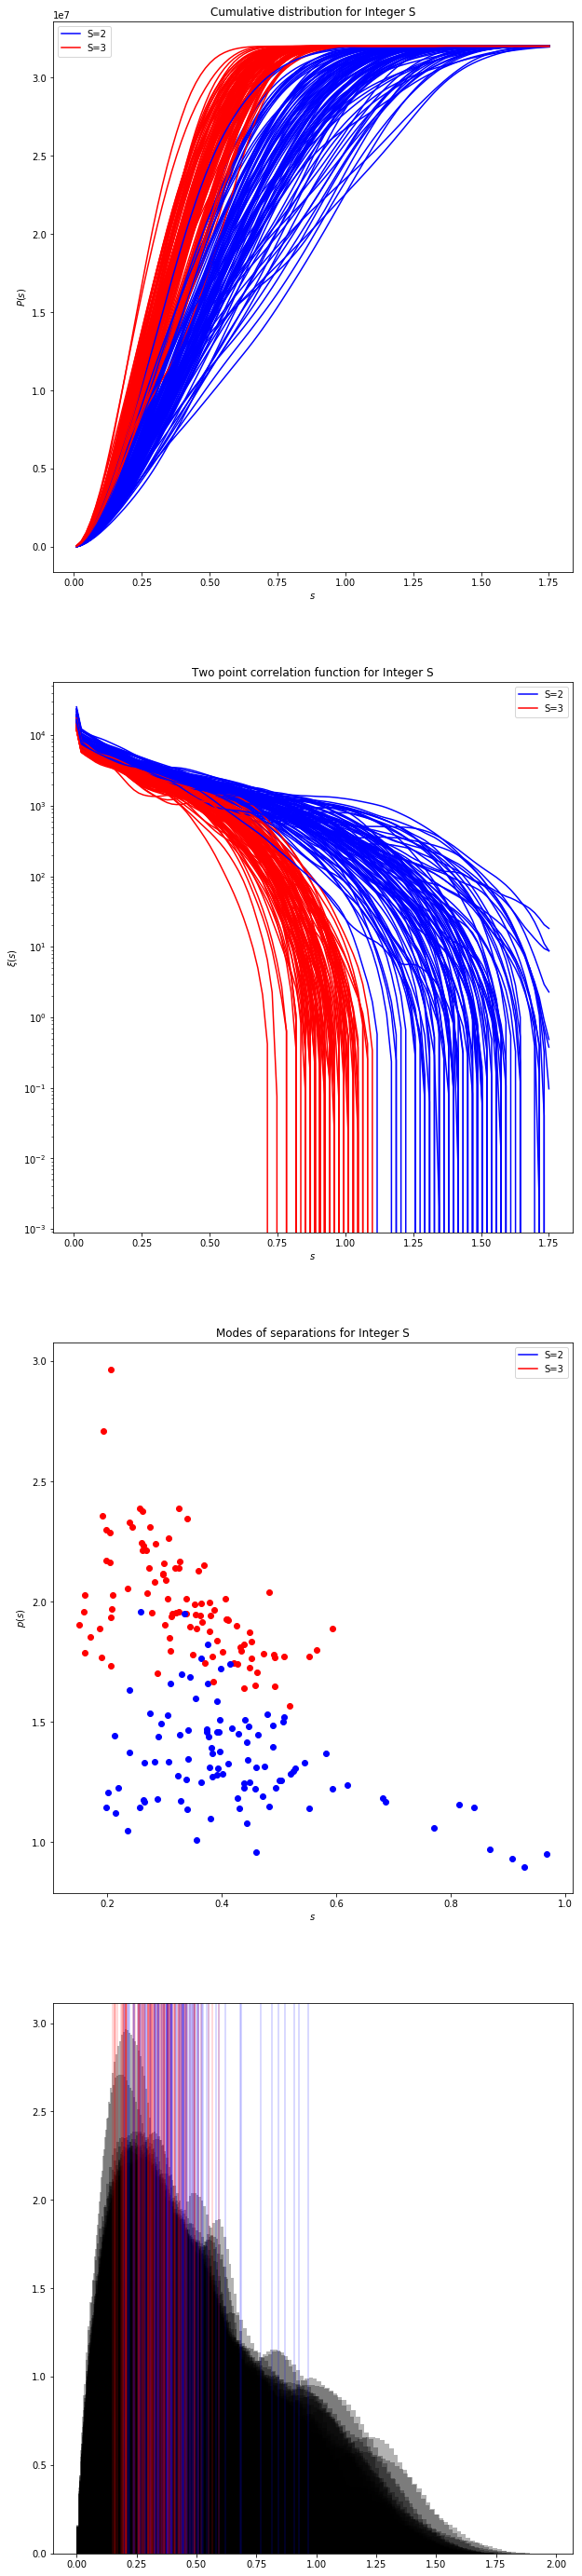

In [5]:
min_stars = 8000
s_factors = np.linspace(0.01,1.75,100)

samples_train = []
labels_train = []

f, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (10,50))
ax1.plot([], label='S=2', color="blue")  
ax1.plot([], label="S=3", color="red")
ax2.plot([], label='S=2', color="blue")  
ax2.plot([], label="S=3", color="red") 
ax3.plot([], label='S=2', color="blue")  
ax3.plot([], label="S=3", color="red")  

for s,g in tqdm(params_train):
    field = fractal_point_gen('S',g,D,E,S=s)
    while len(field[0]) < min_stars:
        print('Number of stars generated:', len(field[0]))
        field = fractal_point_gen('S',g,D,E,S=s)
    culled_field = star_culling(field, min_stars)
    separations = ordered_separations(culled_field)
    P_s = [cum_dist_seps(culled_field,separations,s) for s in s_factors]
    xi = two_pt_corr(field,P_s,s_factors)
    
    n, bins, patches = ax4.hist(separations, bins=100, normed=True, fc='k', alpha=0.3)
    bins_centred = np.array([(bins[i]+bins[i+1])/2 for i in range(100)])                      
    mode = bins_centred[np.argmax(n)]
    
    mean = np.mean(separations)
    variance = np.var(separations)
    skewness = skew(separations)
    kurt = kurtosis(separations)
    
    samples_train.append([mode,mean,variance,skewness,kurt])
    
    s_mode = np.max(n)
    
    if s==2:
        ax1.plot(s_factors,P_s, c='b')
        ax2.plot(s_factors,xi, c='b')
        ax3.scatter(mode,s_mode, c='b')
        ax4.axvline(mode,c='b',alpha=0.2)
        labels_train.append(0)
    if s==3:
        ax1.plot(s_factors,P_s, c='r')
        ax2.plot(s_factors,xi, c='r')
        ax3.scatter(mode,s_mode, c='r')
        ax4.axvline(mode,c='r',alpha=0.2)
        labels_train.append(1)
    
ax1.set_title('Cumulative distribution for Integer S')
ax1.set_ylabel(r'$P(s)$')
ax1.set_xlabel(r'$s$')
ax1.legend()

ax2.set_title('Two point correlation function for Integer S')
ax2.set_ylabel(r'$\xi(s)$')
ax2.set_xlabel(r'$s$')
ax2.legend()
ax2.set_yscale('log')

ax3.set_title('Modes of separations for Integer S')
ax3.set_ylabel(r'$p(s)$')
ax3.set_xlabel(r'$s$')
ax3.legend()

plt.rcParams.update({'font.size': 20})
plt.show()

# Testing

In [6]:
N_fields_test = 50
S_LIST=[2,3]*N_fields_test
G_LIST = [6,4]*N_fields_test
E=2

params_test = np.array([S_LIST,G_LIST]).T
params_test[:10]

array([[2, 6],
       [3, 4],
       [2, 6],
       [3, 4],
       [2, 6],
       [3, 4],
       [2, 6],
       [3, 4],
       [2, 6],
       [3, 4]])

In [7]:
samples_test = []
labels_test = []

for s,g in tqdm(params_test):
    field = fractal_point_gen('S',g,D,E,S=s)
    while len(field[0]) < min_stars:
        print('Number of stars generated:', len(field[0]))
        field = fractal_point_gen('S',g,D,E,S=s)
    culled_field = star_culling(field, min_stars)
    separations = ordered_separations(culled_field)
    P_s = [cum_dist_seps(culled_field,separations,s) for s in s_factors]
    xi = two_pt_corr(field,P_s,s_factors)
    
    n, bins = np.histogram(separations, bins=100, normed=True)
    bins_centred = np.array([(bins[i]+bins[i+1])/2 for i in range(100)])                      
    mode = bins_centred[np.argmax(n)]
    
    mean = np.mean(separations)
    variance = np.var(separations)
    skewness = skew(separations)
    kurt = kurtosis(separations)
    
    samples_test.append([mode,mean,variance,skewness,kurt])
        
    if s==2:
        labels_test.append(0)
    if s==3:
        labels_test.append(1)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [58:35<00:00, 37.78s/it]


In [8]:
X_train = np.array(samples_train)
y_train = np.array(labels_train)

X_test = np.array(samples_test)
y_test = np.array(labels_test)

print(X_train.shape,y_train.shape)
print(X_train,y_train)

(200, 5) (200,)
[[ 2.57641284e-01  5.53914854e-01  9.41106576e-02  1.69741479e-01
  -9.87601766e-01]
 [ 5.65368795e-01  4.02083061e-01  4.85885230e-02 -5.81851093e-03
  -1.16178973e+00]
 [ 9.27883698e-01  6.87423094e-01  1.30646905e-01  1.02865032e-01
  -9.62309502e-01]
 [ 3.12245243e-01  3.55403665e-01  3.01197852e-02  1.84584583e-01
  -6.79180668e-01]
 [ 4.28024904e-01  5.74456639e-01  9.44559663e-02  3.30274686e-01
  -6.93571260e-01]
 [ 3.24745379e-01  3.30383159e-01  2.76869570e-02  2.69634046e-01
  -5.74870185e-01]
 [ 3.83268363e-01  5.04438449e-01  7.53450344e-02  4.62133792e-01
  -3.89542541e-01]
 [ 4.39228641e-01  3.80444348e-01  3.86193526e-02  8.01271266e-02
  -8.71163795e-01]
 [ 4.45234705e-01  5.19205640e-01  7.75844209e-02  4.03895552e-01
  -3.98893240e-01]
 [ 4.92901497e-01  3.93613370e-01  4.13963315e-02  1.46021510e-01
  -8.49534565e-01]
 [ 2.64103485e-01  5.73041907e-01  1.04269160e-01  1.90887951e-01
  -1.04220645e+00]
 [ 4.62116033e-01  3.60551485e-01  3.53253376e-02

  -5.78057373e-01]] [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


In [9]:
from sklearn import svm
from sklearn import metrics

clf = svm.SVC()
clf.fit(X_train, y_train)
y_preds = clf.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.94

In [11]:
print('Accuracy: ',metrics.accuracy_score(y_test,y_preds))

Accuracy:  0.94


# To do list:

- SVM for mode, also try for skewness, kurtosis, mean, median etc. **Done**
- Build CNN on Density field, increase number of points by increasing G in order to fill in the 2d histogram.
- Investigate area under curve of cumulative distribution for s>0.7